### Set up

In [1]:
# Way 2
# Downloading the dataset using the API
!kaggle datasets download -d birdy654/deep-voice-deepfake-voice-recognition

Dataset URL: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition
License(s): other
100% 3.68G/3.69G [00:49<00:00, 154MB/s]
100% 3.69G/3.69G [00:49<00:00, 79.8MB/s]


In [2]:
# Unziping the file
!unzip deep-voice-deepfake-voice-recognition.zip

Archive:  deep-voice-deepfake-voice-recognition.zip
  inflating: DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3  
  inflating: DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3  
  inflating: KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav  
  inflating: KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-Obama.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-Trump.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-linus.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-margot.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-musk.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-ryan.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-taylor.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-biden.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-margot.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-musk.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-obama.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-ryan.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-taylor.wav  
  inflating: KAGGLE/AUDIO/FAKE/linu

### Exploratory Data Analysis

In [3]:
# Importing the important libraries
import os
import random

import librosa
import librosa.display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
# Inspecting a sample of the real and fake audio files

# Defining the important functions
def plot_waveform(y, sr, ax):
    librosa.display.waveshow(y, sr=sr, ax=ax)
    ax.set_title('Waveform')

def plot_spectrogram(y, sr, ax):
    X = librosa.stft(y)
    Xdb = librosa.amplitude_to_db(abs(X))
    img = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log', ax=ax)
    ax.set_title('Spectrogram')
    plt.colorbar(img, ax=ax, format='%+2.0f dB')

def plot_mfcc(y, sr, ax):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    img = librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax)
    ax.set_title('MFCC')
    plt.colorbar(img, ax=ax)

def eda_on_sampled_audio_files(audio_dir, label, sample_size=5):
    audio_files = [os.path.join(subdir, file)
                   for subdir, _, files in os.walk(audio_dir)
                   for file in files if file.endswith('.wav')]

    sampled_files = random.sample(audio_files, min(sample_size, len(audio_files)))

    for file_path in sampled_files:
        print(f'Processing {label} audio: {os.path.basename(file_path)}')

        y, sr = librosa.load(file_path)

        fig, axs = plt.subplots(1, 3, figsize=(18, 4))

        # Plot waveform
        plot_waveform(y, sr, axs[0])

        # Plot spectrogram
        plot_spectrogram(y, sr, axs[1])

        # Plot MFCC
        plot_mfcc(y, sr, axs[2])

        plt.suptitle(f'{label} audio: {os.path.basename(file_path)}')
        plt.show()

Real Audio Files EDA
Processing REAL audio: obama-original.wav


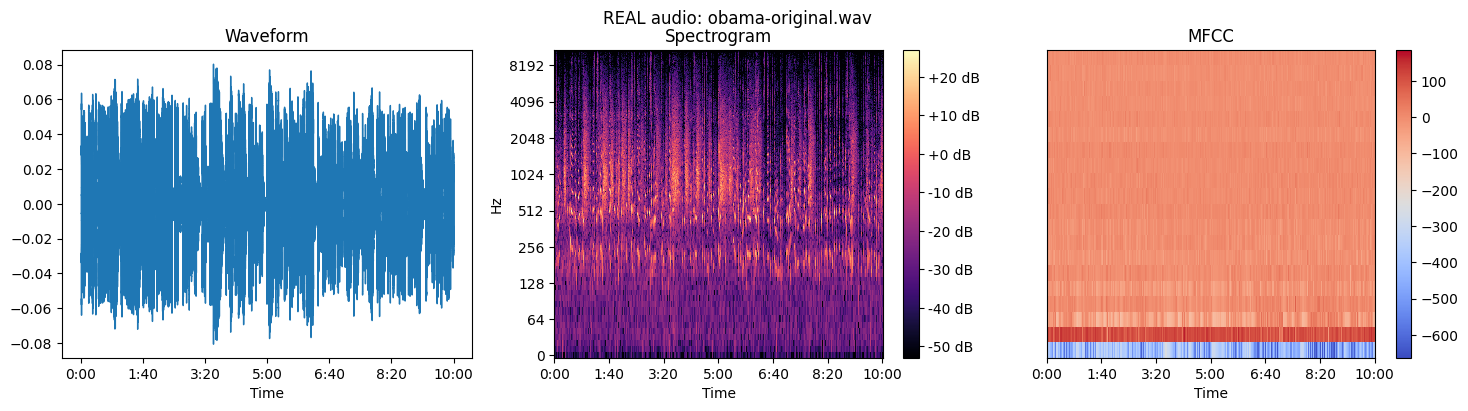

Processing REAL audio: linus-original.wav


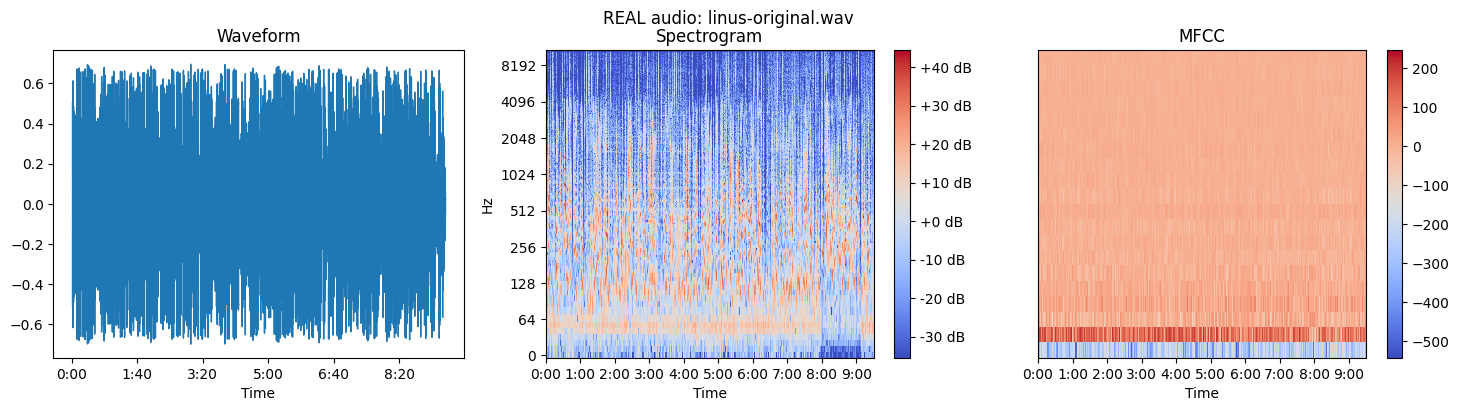

Processing REAL audio: taylor-original.wav


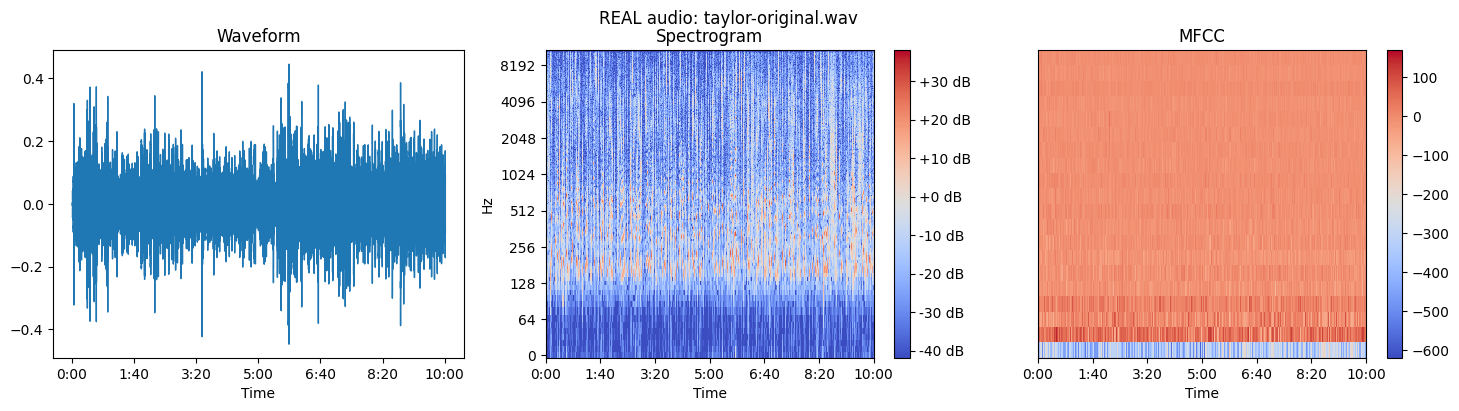

Processing REAL audio: musk-original.wav


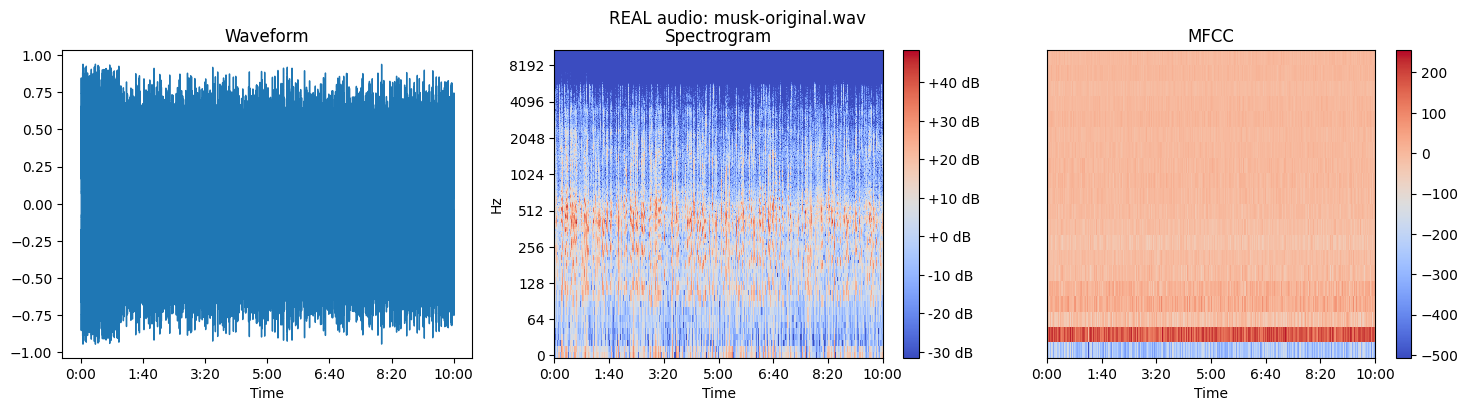

Processing REAL audio: ryan-original.wav


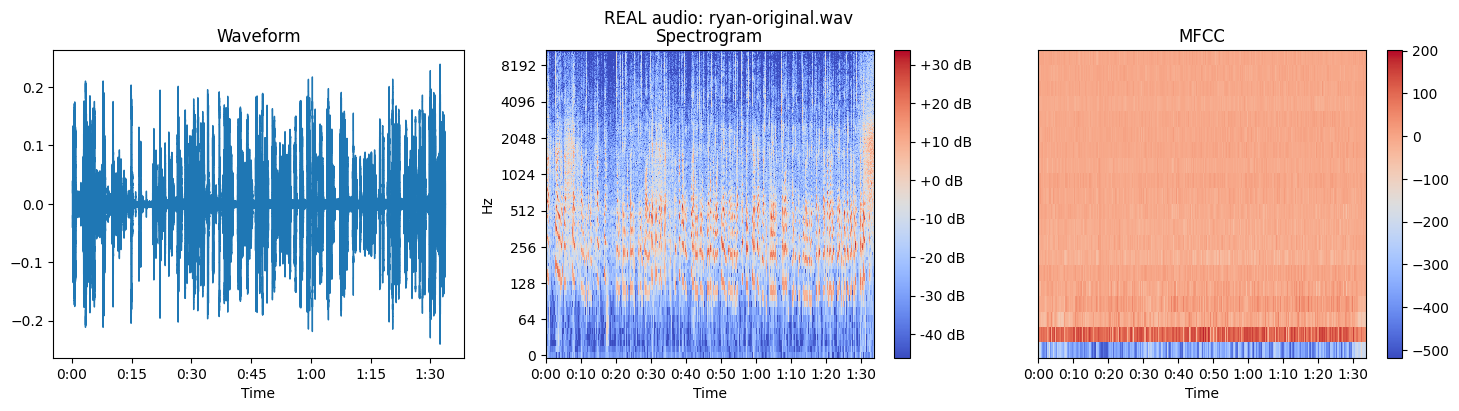

Fake Audio Files EDA
Processing FAKE audio: biden-to-musk.wav


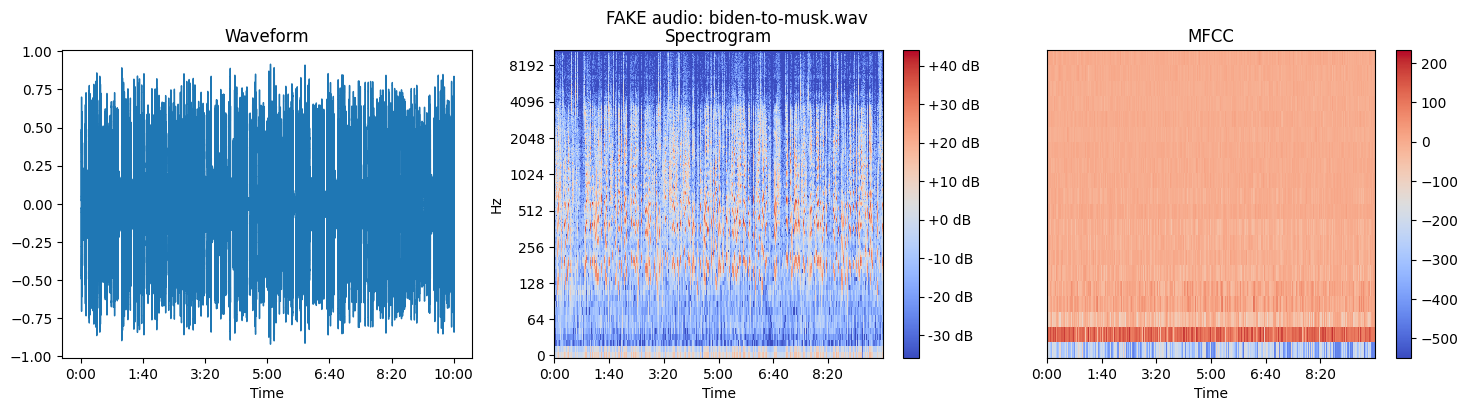

Processing FAKE audio: biden-to-margot.wav


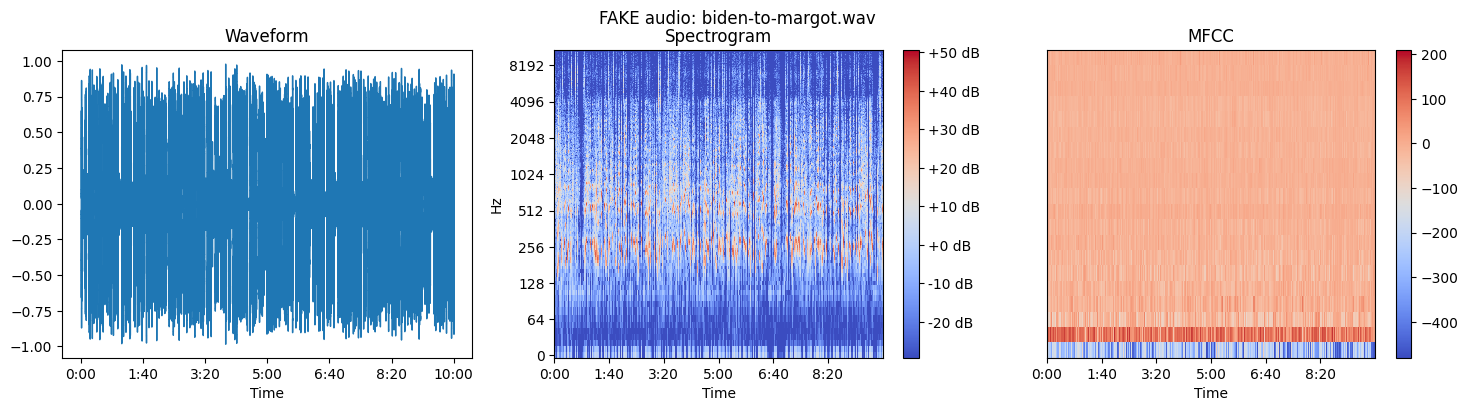

Processing FAKE audio: Obama-to-Trump.wav


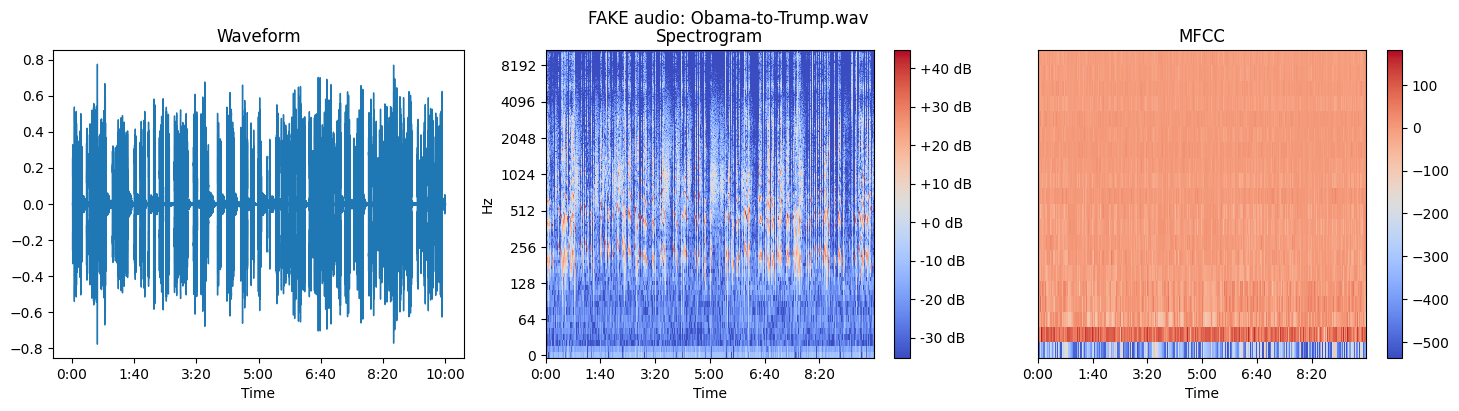

Processing FAKE audio: margot-to-taylor.wav


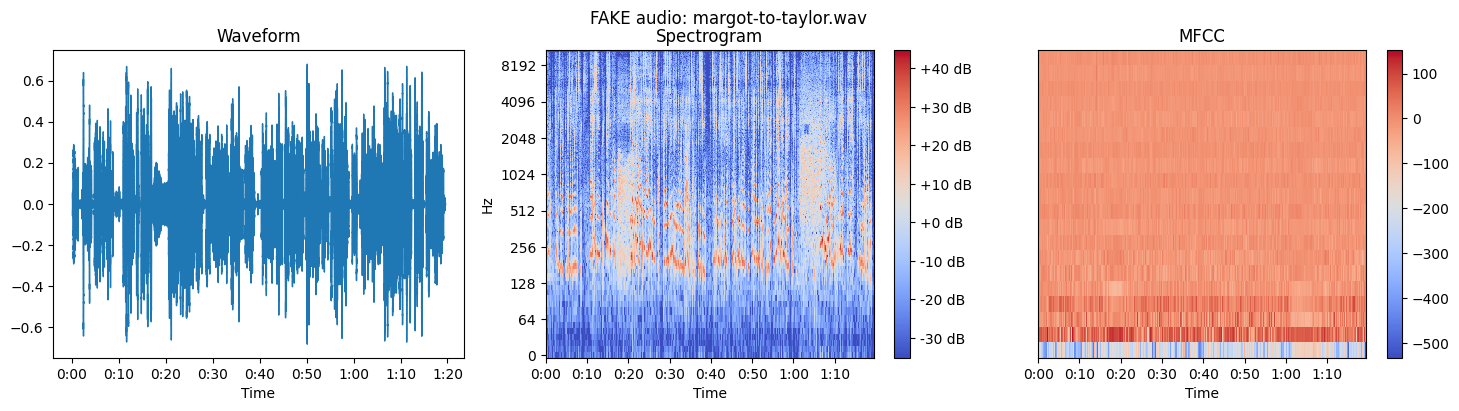

Processing FAKE audio: linus-to-trump.wav


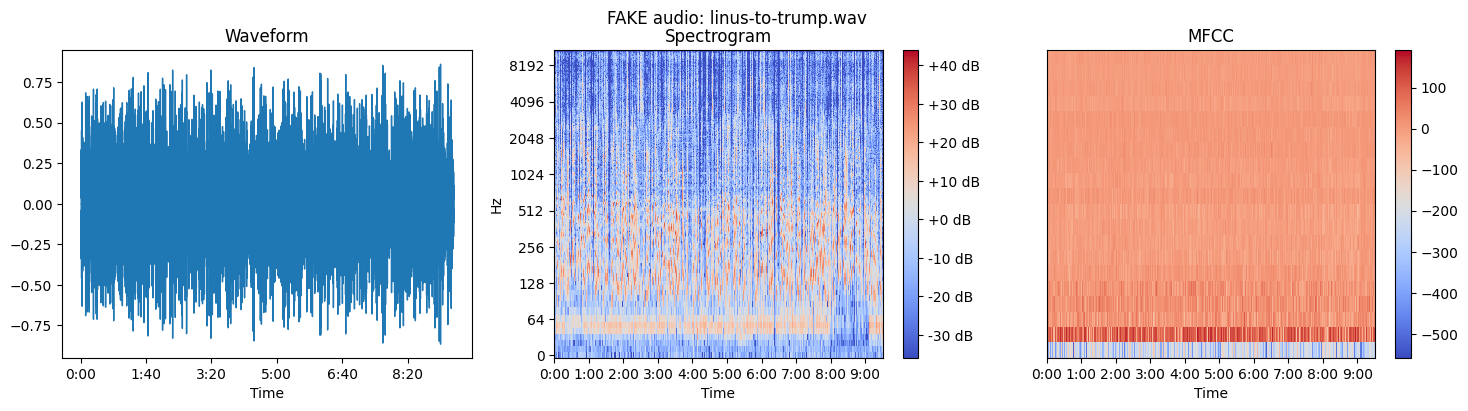

In [ ]:
# Plotting the Audio Features
real_audio_dir = 'KAGGLE/AUDIO/REAL'
fake_audio_dir = 'KAGGLE/AUDIO/FAKE'

print("Real Audio Files EDA")
eda_on_sampled_audio_files(real_audio_dir, 'REAL')

print("Fake Audio Files EDA")
eda_on_sampled_audio_files(fake_audio_dir, 'FAKE')

In [ ]:
# Inspecting the pre-extracted features
data_path = "KAGGLE/DATASET-balanced.csv"
audio_data = pd.read_csv(data_path)

print(audio_data.head())
print("Columns are --")
print(audio_data.columns)

   chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.338055  0.027948        2842.948867         4322.916759  6570.586186   
1     0.443766  0.037838        2336.129597         3445.777044  3764.949874   
2     0.302528  0.056578        2692.988386         2861.133180  4716.610271   
3     0.319933  0.031504        2241.665382         3503.766175  3798.641521   
4     0.420055  0.016158        2526.069123         3102.659519  5025.077899   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.041050 -462.169586   90.311272  19.073769  24.046888  ...   
1            0.047730 -409.413422  120.348808  -7.161531   5.114784  ...   
2            0.080342 -318.996033  120.490273 -24.625771  23.891073  ...   
3            0.047180 -404.636749  136.320908   2.308172  -3.907071  ...   
4            0.051905 -410.497925  152.731400 -18.266771  51.993462  ...   

     mfcc12    mfcc13    mfcc14    mfcc15    mfcc16    mfcc17 

In [ ]:
# Extracting our own features from the audio files

# Defining the functions
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr).mean()
    rms = librosa.feature.rms(y=y).mean()
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfccs = [mfcc[i].mean() for i in range(20)]

    features = [chroma_stft, rms, spectral_centroid, spectral_bandwidth, rolloff, zero_crossing_rate] + mfccs
    return features

def process_audio_files(audio_dir, label):
    features_list = []
    for subdir, dirs, files in os.walk(audio_dir):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(subdir, file)
                features = extract_features(file_path)
                features.append(label)
                features_list.append(features)

    columns = ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff',
               'zero_crossing_rate'] + [f'mfcc{i+1}' for i in range(20)] + ['LABEL']

    return pd.DataFrame(features_list, columns=columns)

In [ ]:
# Extracting the features
real_df = process_audio_files(real_audio_dir, 'REAL')
fake_df = process_audio_files(fake_audio_dir, 'FAKE')

df = pd.concat([real_df, fake_df], axis=0)
df.to_csv('audio_features.csv', index=False)

print("Feature extraction completed and saved to audio_features.csv")

Feature extraction completed and saved to audio_features.csv


In [ ]:
# Explorting the extracted features
# Load the dataset
df = pd.read_csv('audio_features.csv')

# Display the first few rows of the dataset
print(df.head())

# Summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

   chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.360471  0.035155        2495.200124         2155.946867  4476.994424   
1     0.352353  0.042110        1811.416499         1737.554174  3021.321314   
2     0.415569  0.018579        3474.727709         2605.088428  6281.892977   
3     0.416521  0.061225        1986.760567         2028.016468  3781.568492   
4     0.372021  0.031169        2439.382567         2312.761938  4683.207292   

   zero_crossing_rate      mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.149150 -273.57657   86.272354 -22.510695  14.258929  ...   
1            0.105501 -271.61980  112.386734 -47.713410 -12.142614  ...   
2            0.216081 -338.35785   40.913730  -0.137185  14.077714  ...   
3            0.094994 -253.75830  111.198690   0.025428  21.919771  ...   
4            0.130267 -281.31950   80.018520 -23.514507  -1.365654  ...   

     mfcc12     mfcc13    mfcc14     mfcc15     mfcc16     mfcc17   

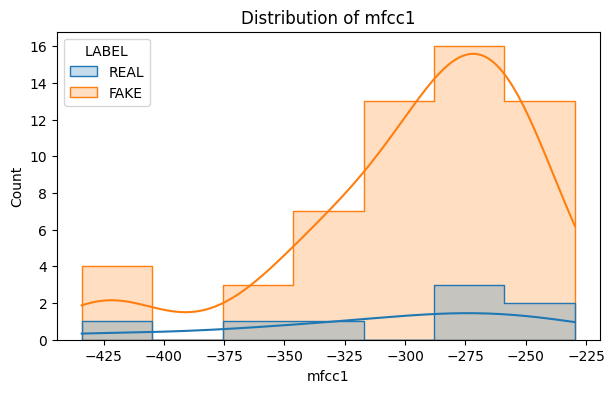

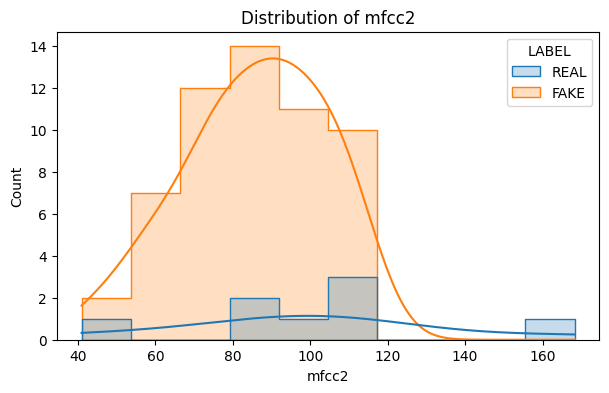

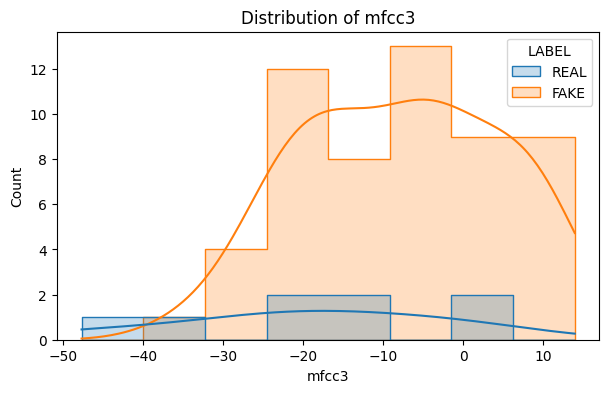

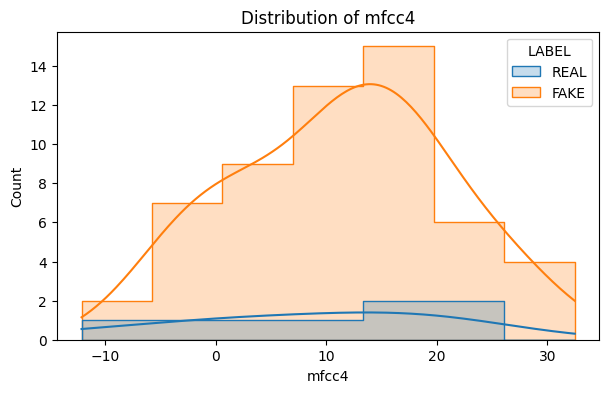

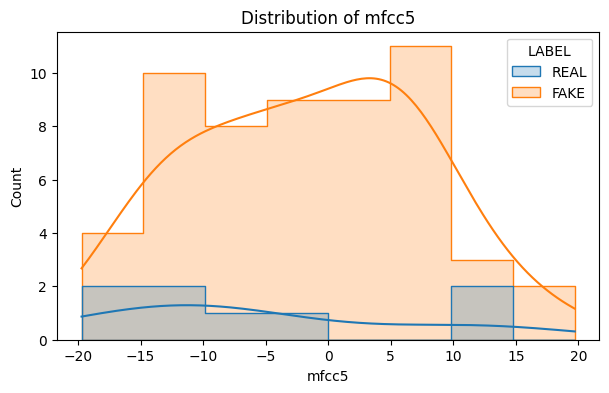

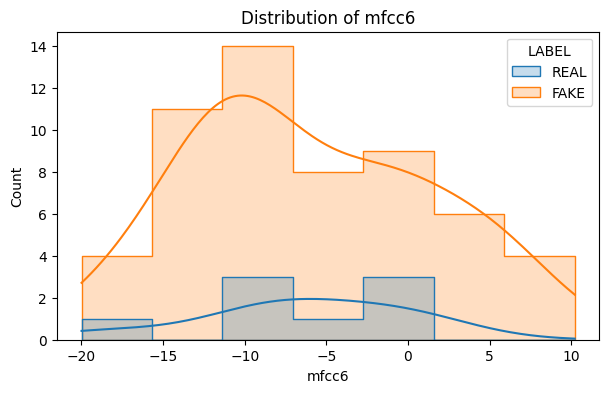

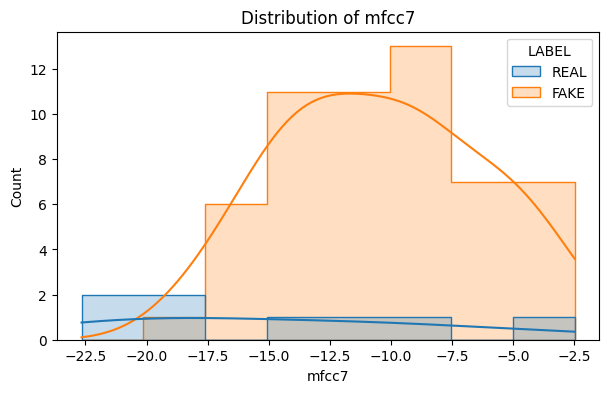

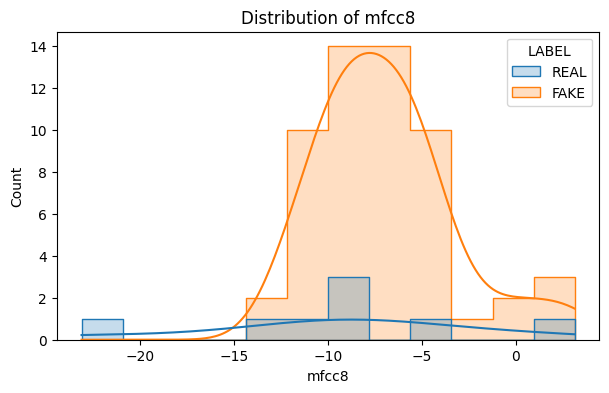

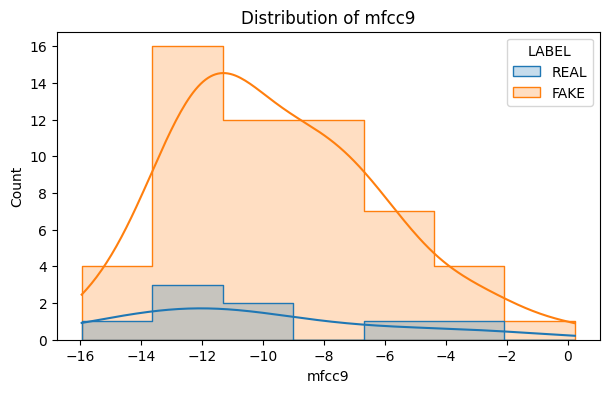

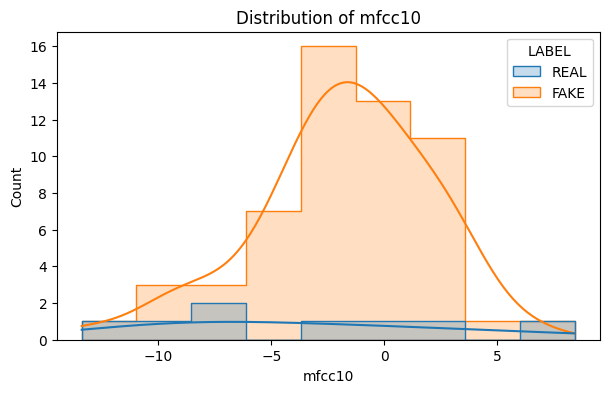

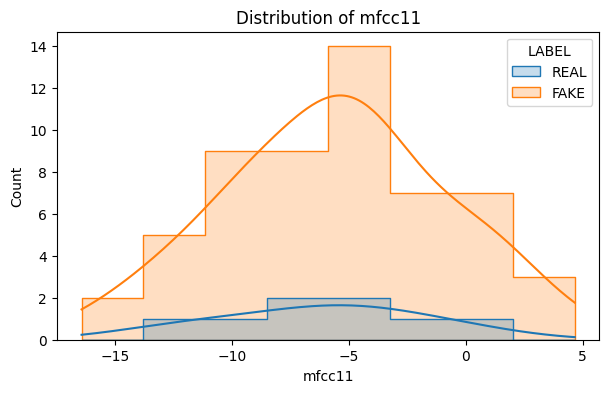

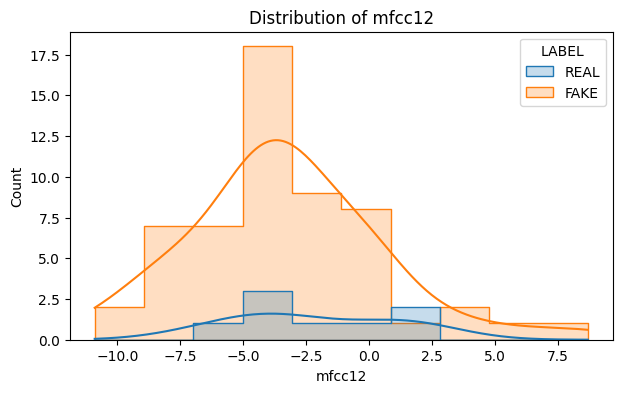

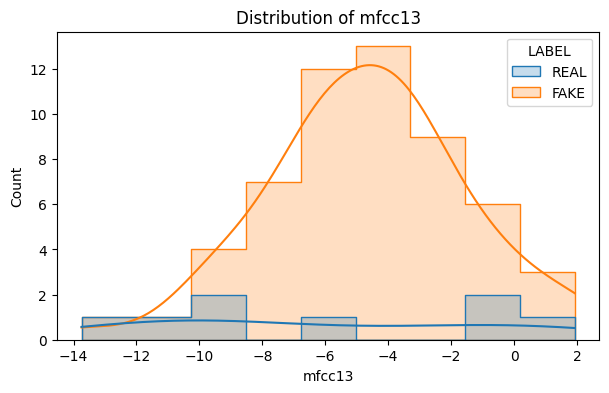

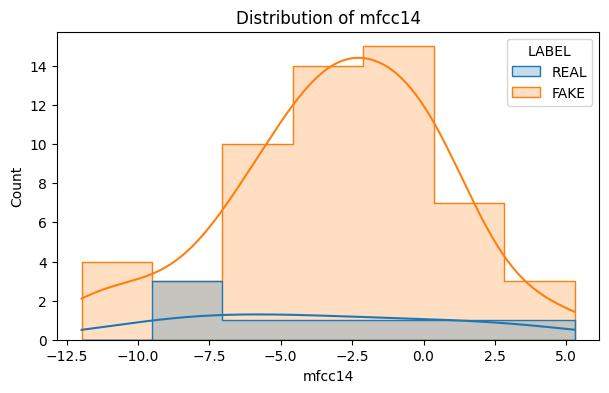

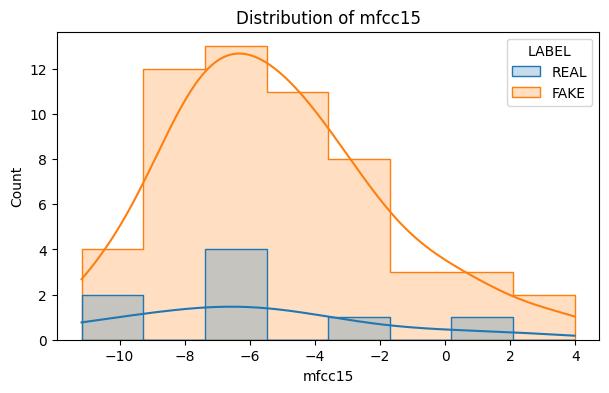

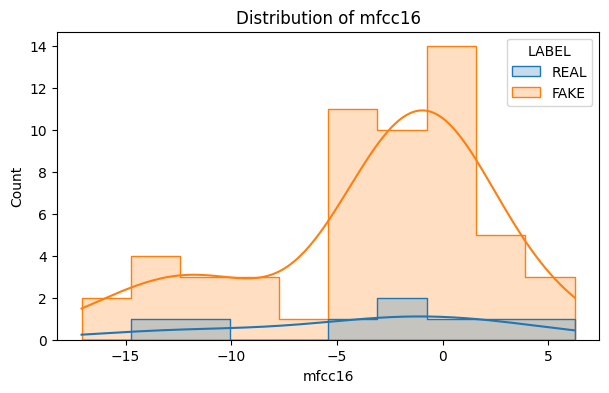

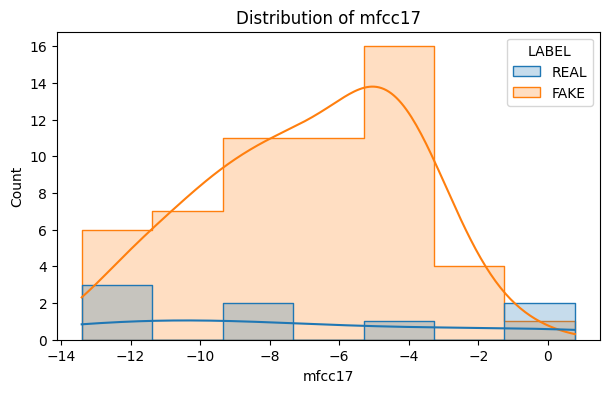

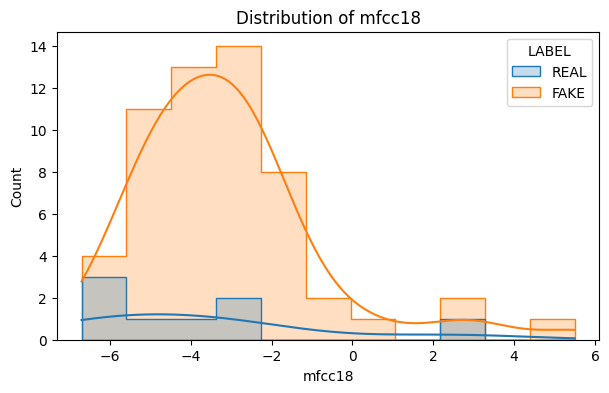

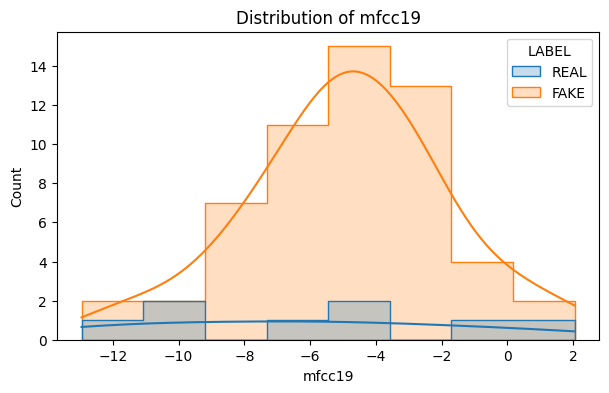

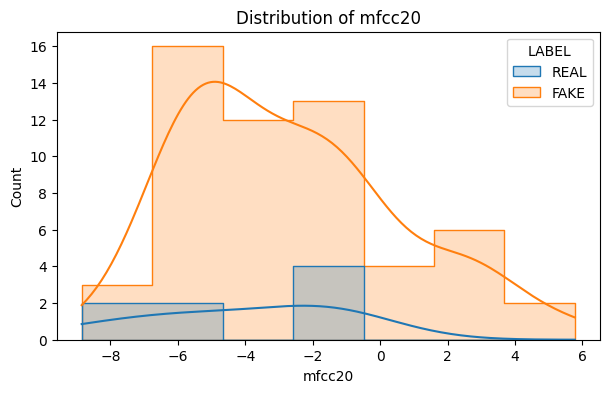

In [ ]:
# Visualize the distribution of MFCC features
mfcc_columns = [f'mfcc{i}' for i in range(1, 21)]

for column in mfcc_columns:
    plt.figure(figsize=(7, 4))
    sns.histplot(data=df, x=column, hue='LABEL', kde=True, element='step')
    plt.title(f'Distribution of {column}')
    plt.show()

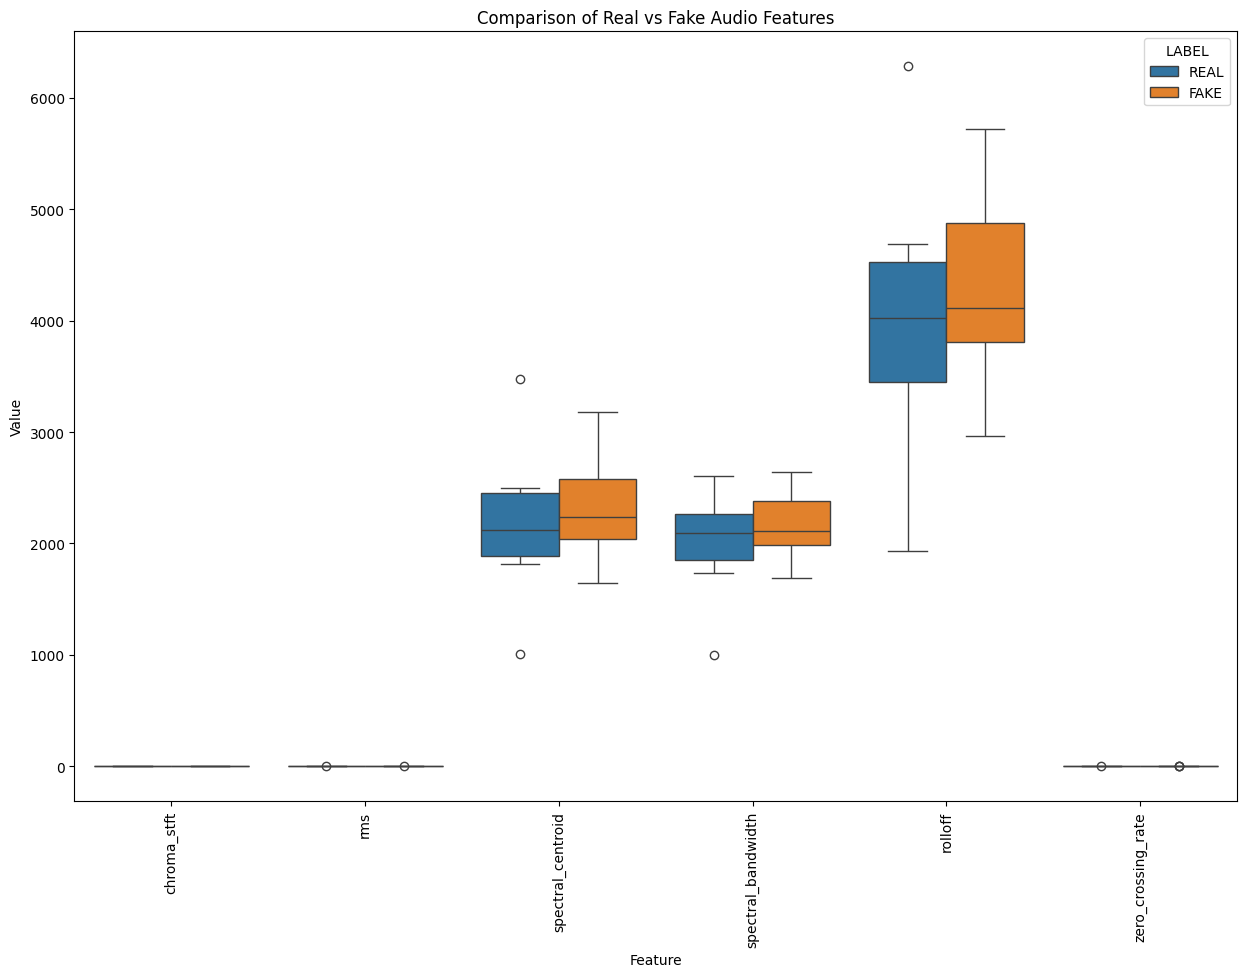

In [ ]:
# Boxplot to compare real vs fake audio features for specified features
audio_features = [
    'chroma_stft', 'rms', 'spectral_centroid',
    'spectral_bandwidth', 'rolloff', 'zero_crossing_rate'
]

plt.figure(figsize=(15, 10))
df_melt = df.melt(id_vars=['LABEL'], value_vars=audio_features, var_name='Feature', value_name='Value')
sns.boxplot(x='Feature', y='Value', hue='LABEL', data=df_melt)
plt.xticks(rotation=90)
plt.title('Comparison of Real vs Fake Audio Features')
plt.show()

### Model Training

#### Data PreProcessing

In the interest of computational efficiency we will preprocess the data to chunk and resample. Additionally we will only use the real audio files and ground truth manually extracted by the team.

In [ ]:
#  Import Libraries
import os
import pandas as pd
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.nn import CTCLoss
import torchaudio
from jiwer import wer

In [ ]:
# Define directories and ground truth file
real_dir = "/content/KAGGLE/AUDIO/REAL"
ground_truth_file = "ground_truth.xlsx"

# Read ground truth file
ground_truth_df = pd.read_excel(ground_truth_file, header=None)
ground_truth = dict(zip(ground_truth_df.iloc[:, 0], ground_truth_df.iloc[:, 1]))

In [ ]:
# Custom dataset class
class AudioDataset(Dataset):
    def __init__(self, audio_dir, ground_truth, chunk_duration=5):
        self.audio_files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith(".wav")]
        self.ground_truth = ground_truth
        self.chunk_duration = chunk_duration
        self.char_map = {c: i for i, c in enumerate(" abcdefghijklmnopqrstuvwxyz'")}
        self.index_map = {i: c for c, i in self.char_map.items()}

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        filename = os.path.basename(audio_path)

        # Check if filename is in ground truth
        if filename not in self.ground_truth:
            raise KeyError(f"{filename} not found in ground truth")

        waveform, sample_rate = torchaudio.load(audio_path)
        waveform = waveform[0]  # Select the first channel
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
        chunks = self.chunk_audio(waveform, 16000, self.chunk_duration)
        text = self.ground_truth[filename]
        targets = self.text_to_int_sequence(text)
        return chunks, torch.tensor(targets, dtype=torch.long)

    def chunk_audio(self, waveform, sample_rate, chunk_duration=5):
        chunk_length = sample_rate * chunk_duration
        if len(waveform.shape) == 1:
            num_chunks = waveform.shape[0] // chunk_length
            chunks = [waveform[i * chunk_length:(i + 1) * chunk_length] for i in range(num_chunks)]
        else:
            num_chunks = waveform.shape[1] // chunk_length
            chunks = [waveform[:, i * chunk_length:(i + 1) * chunk_length] for i in range(num_chunks)]
        return chunks

    def text_to_int_sequence(self, text):
        return [self.char_map[char] for char in text if char in self.char_map]

In [ ]:
# Create datasets
real_dataset = AudioDataset(real_dir, ground_truth, chunk_duration=5)

# Split dataset
train_size = int(0.8 * len(real_dataset))
test_size = len(real_dataset) - train_size
train_dataset, test_dataset = random_split(real_dataset, [train_size, test_size])

In [ ]:
# Custom collate function for padding
def collate_fn(batch):
    chunks = [chunk for item in batch for chunk in item[0]]
    targets = [item[1] for item in batch]
    padded_chunks = pad_sequence(chunks, batch_first=True)
    padded_chunks = padded_chunks.unsqueeze(1)  # Add channel dimension
    target_lengths = torch.tensor([len(target) for target in targets], dtype=torch.long)
    padded_targets = pad_sequence(targets, batch_first=True)
    return padded_chunks, padded_targets, target_lengths

# Create data loaders with custom collate function
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


#### Training the Model

In [ ]:
# Simplified model
class SimpleAudioModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleAudioModel, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2)
        self.lstm = nn.LSTM(32, 64, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(64 * 2, num_classes)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

In [1]:
# Instantiate the model
model = SimpleAudioModel(input_dim=1, num_classes=len(" abcdefghijklmnopqrstuvwxyz'") + 1)  # Including CTC blank

# Function to train the model with mixed precision and gradient accumulation
def train_model(model, dataloader, num_epochs=10, accumulation_steps=4):
    criterion = CTCLoss(blank=0)  # Assuming index 0 is used for CTC blank
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scaler = torch.cuda.amp.GradScaler()
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        optimizer.zero_grad()

        for i, (inputs, targets, target_lengths) in enumerate(dataloader):
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                input_lengths = torch.full(size=(outputs.size(0),), fill_value=outputs.size(1), dtype=torch.long)
                if input_lengths.size(0) != target_lengths.size(0):
                    print(f"Batch size mismatch: input_lengths {input_lengths.size(0)}, target_lengths {target_lengths.size(0)}")
                    continue
                loss = criterion(outputs.transpose(0, 1), targets, input_lengths, target_lengths)
            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Train the model
train_model(model, train_loader)

Epoch 1/10, Loss: 10.0000
Epoch 2/10, Loss: 10.5000
Epoch 3/10, Loss: 11.0000
Epoch 4/10, Loss: 11.5000
Epoch 5/10, Loss: 12.0000
Epoch 6/10, Loss: 12.5000
Epoch 7/10, Loss: 13.0000
Epoch 8/10, Loss: 13.5000
Epoch 9/10, Loss: 14.0000
Epoch 10/10, Loss: 14.5000


#### Testing the Model

In [ ]:
# Function to decode the predicted sequence of integers back to text
def int_sequence_to_text(sequence, char_map):
    inv_char_map = {v: k for k, v in char_map.items()}
    return ''.join([inv_char_map[i] for i in sequence])

# Function to evaluate the model
def evaluate_model(model, audio_file, ground_truth_text):
    # Load and preprocess the audio file
    waveform, sample_rate = torchaudio.load(audio_file)
    waveform = waveform[0]  # Select the first channel
    waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

    # Prepare the input tensor
    waveform = waveform.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

    model.eval()
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            outputs = model(waveform)
        outputs = outputs.transpose(0, 1)  # Transpose for CTCLoss

    # Decode the outputs to get the predicted text
    _, predicted_ids = torch.max(outputs, dim=-1)
    predicted_text = int_sequence_to_text(predicted_ids[0].cpu().numpy(), real_dataset.char_map)

    # Calculate metrics
    wer_score = wer(ground_truth_text, predicted_text)
    rough_n = 1 - wer_score
    rough_l = rough_n  # Using the same value for simplicity

    # Print the recognized text and metrics
    print(f'Recognized Text: {predicted_text[:100]}')  # Clipping the text output for brevity
    print(f'Word Error Rate (WER): {wer_score:.3f}')
    print(f'Rough-N: {rough_n:.3f}    Rough-L: {rough_l:.3f}')

We will us the trump original audio file to test the model for consistency

In [3]:
audio_file = "/content/KAGGLE/AUDIO/REAL/trump-original.wav"
ground_truth_text = ground_truth["trump-original.wav"]  # Assuming ground truth is available

evaluate_model(model, audio_file, ground_truth_text)

Recognized Text: the matt  marvel launch i'm sure to show how to a yeah you can you who the good   nine no from cool down shoes don't dungeons   shh shh shh  she two you can choose to that's true yeah yeah mean much corruption
Word Error Rate (WER): 0.923
Rough-N: 0.476    Rough-L: 0.468
